## Vancouver Crime Exploratory Data Analysis with Folium Map Feature

Personal project: to visualize crime data trends in Vancouver.

This notebook consists of 2 parts: <br>
Part 1 contains plots of Vancouver crime data trends. <br>
Part 2 contains interactive heat map of the crime occurrences in Vancouver.

Data set: was obtained from Kaggle [link](https://www.kaggle.com/datasets/sumaiaparveenshupti/vancouver-bc-historical-crime-data?resource=download), and contains Vancouver's Police Department released data from 2017 to 2021.

### Getting started
Importing all the neccessary libraries, including folium module that will be used to create a heat map

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
from folium.plugins import HeatMap
import pyproj
import warnings
warnings.filterwarnings('ignore')

In [2]:
# to clean the data, will remove rows with any missing values
data = pd.read_csv('crimedata_csv_all_years.csv')
data = data.dropna()
data.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Theft from Vehicle,2006,3,4,20,30,DAVIE ST / HOWE ST,Central Business District,490748.5904,5.458346e+06
1,Theft from Vehicle,2006,3,5,11,30,DAVIE ST / HOWE ST,Central Business District,490748.5904,5.458346e+06
2,Theft from Vehicle,2006,4,16,0,1,DAVIE ST / HOWE ST,Central Business District,490748.5904,5.458346e+06
3,Theft from Vehicle,2006,6,11,17,45,DAVIE ST / HOWE ST,Central Business District,490748.5904,5.458346e+06
4,Theft from Vehicle,2006,8,5,20,0,DAVIE ST / HOWE ST,Central Business District,490748.5904,5.458346e+06


### Part 1: Data Visualization

In [3]:
# The data set contains the following types of crime
types = data['TYPE'].value_counts().to_frame().reset_index()
types

,TYPE,count
0,Theft from Vehicle,224660
1,Other Theft,192649
2,Mischief,92912
3,Break and Enter Residential/Other,69365
4,Offence Against a Person,67424
5,Break and Enter Commercial,43066
6,Theft of Vehicle,42793
7,Theft of Bicycle,33763
8,Vehicle Collision or Pedestrian Struck (with I...,26556
9,Vehicle Collision or Pedestrian Struck (with F...,304


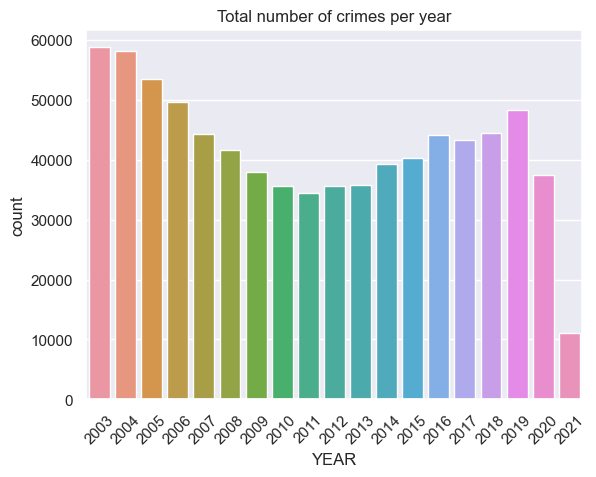

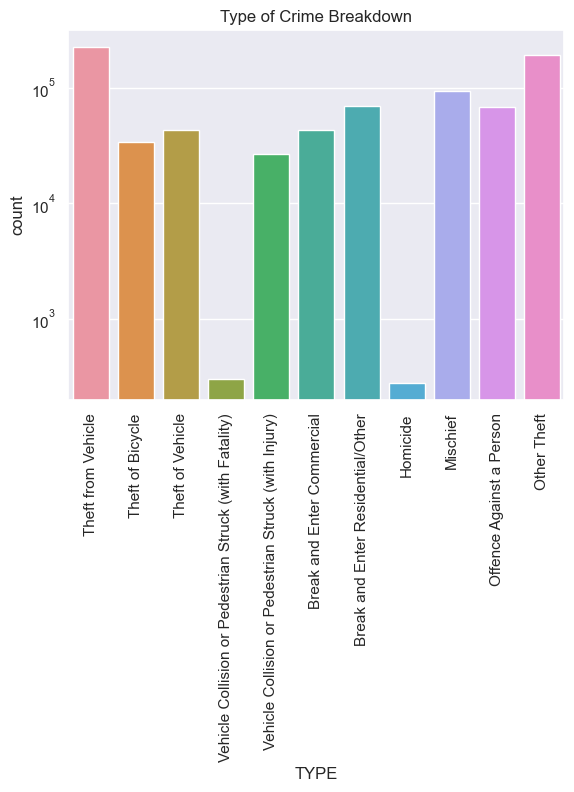

In [4]:
# to identify the area of focus will make two plots: breakdown by year and by crime type
sns.set(style='darkgrid')

sns.countplot(x='YEAR', data=data)
plt.xticks(rotation=45)
plt.title('Total number of crimes per year')
plt.show()

sns.countplot(x='TYPE', data=data)
plt.xticks(rotation=90)
plt.title('Type of Crime Breakdown')
plt.yscale('log')
plt.show()

The table and graphs above indicate that theft, mischief and break & enter are the most frequent crimes through the years. From here I will focus on theft from vehicle and break and enter data.

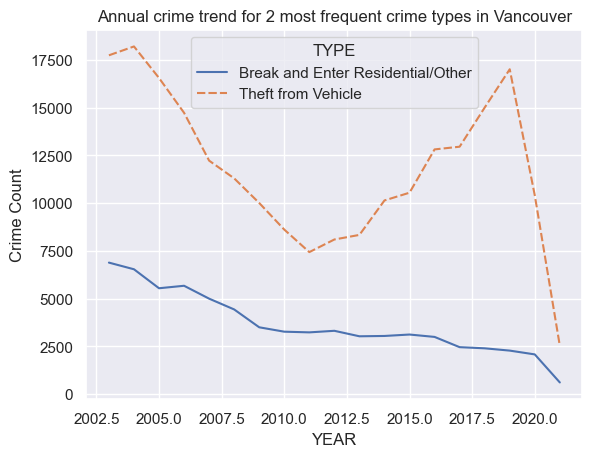

In [5]:
# Will plot annual trends for Break & Enter and Theft from Vehicle crimes
df = data[(data['TYPE']=='Break and Enter Residential/Other') | (data['TYPE']=='Theft from Vehicle')]
df1 = df.groupby(['YEAR','TYPE']).size().reset_index(name='Count')

sns.lineplot(data=df1, x='YEAR', y='Count', hue='TYPE',style='TYPE')
plt.title('Annual crime trend for 2 most frequent crime types in Vancouver')
plt.ylabel('Crime Count')
plt.show()

Break and Enter crime rates seem to be going down; however, Theft from Vehicles continue to have unpredicted behaviour with the rates going down after a spike in 2018-2019, which can be attributed to the lack of data for the last year 2021.

Will therefore focus on 2020 data as the most recent year to today's date with adequate amount of data points.

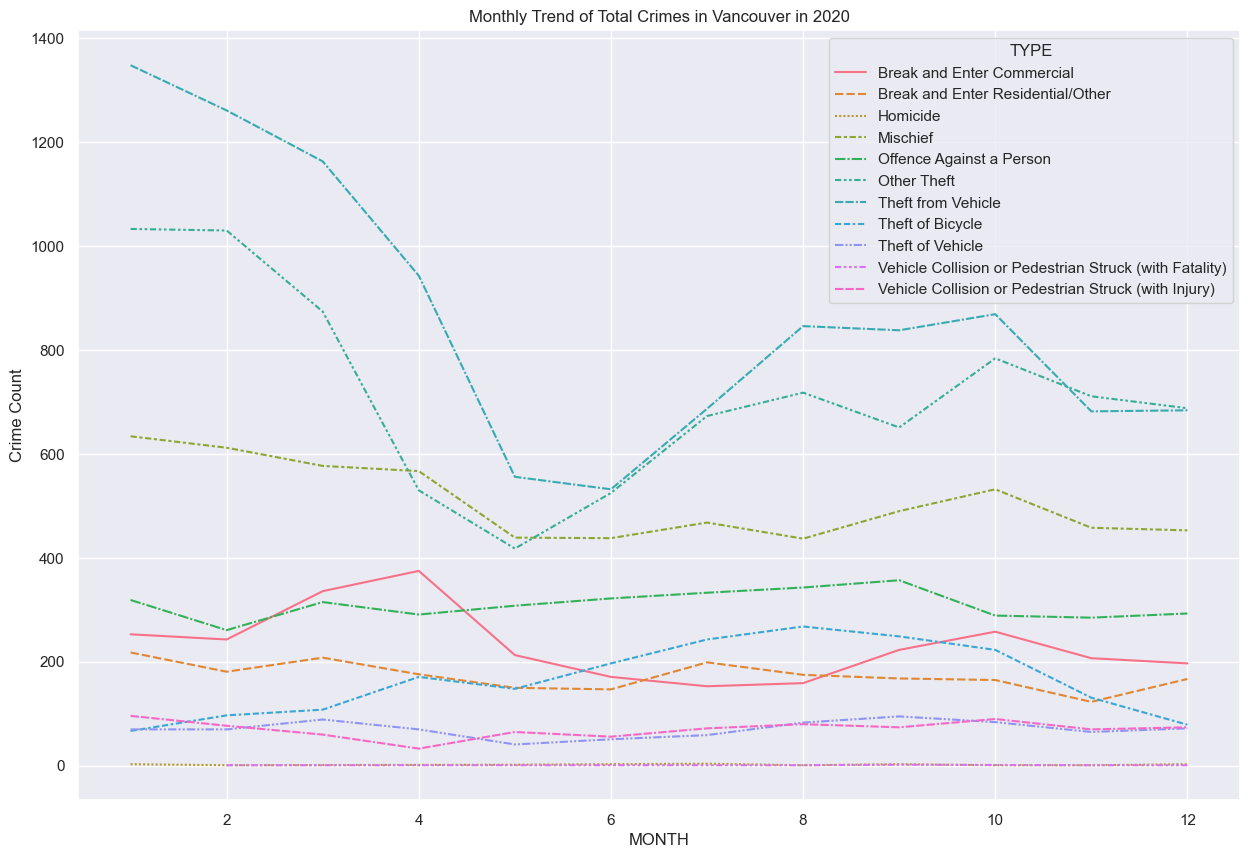

In [6]:
data2020 = data[data['YEAR']==2020]

# Will plot montly trend of each type of crime in 2020
df = data2020.groupby(['TYPE','MONTH']).size().reset_index(name='Count')

plt.figure(figsize=(15,10))
sns.lineplot(data=df, x='MONTH', y='Count', hue='TYPE', style='TYPE')
plt.title('Monthly Trend of Total Crimes in Vancouver in 2020')
plt.ylabel('Crime Count')
plt.show()

It looks like most of the crimes are independent of the time of year except for Theft of Vehicles and Bicycles that display lower occurerence during summer months.

#### Next, will plot crime occurrence in Neighbourhoods
Will display only 3 plots: for Break & Enter, Offence Against a Person and Homicide as these are the crime that affect immediate safety of a person, and therefore are of interest for me.

In [7]:
'''declare a plot function that takes a type of crime as input,
   and returns a bar plot of crime occurrence in each neighbourhood.'''

def where_crime_plot(crime):
    df = data2020[data2020['TYPE']== crime].groupby('NEIGHBOURHOOD').size().reset_index(name='Count')
    df = df.sort_values(by='Count', ascending=False)
    plt.figure(figsize=(10,5))
    
    sns.barplot(data=df, x='Count', y='NEIGHBOURHOOD', orient='h')
    plt.ylabel('Neighbourhood')
    plt.xlabel('Total Crime Count')
    plt.title('Where '+str(crime)+' occurred in 2020')
    plt.show()
    
    return

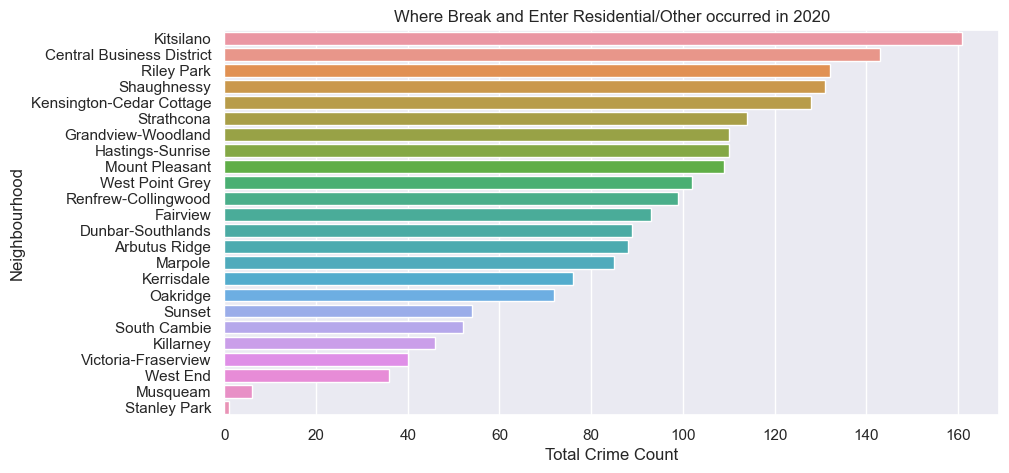

In [8]:
# plot 1
where_crime_plot('Break and Enter Residential/Other')

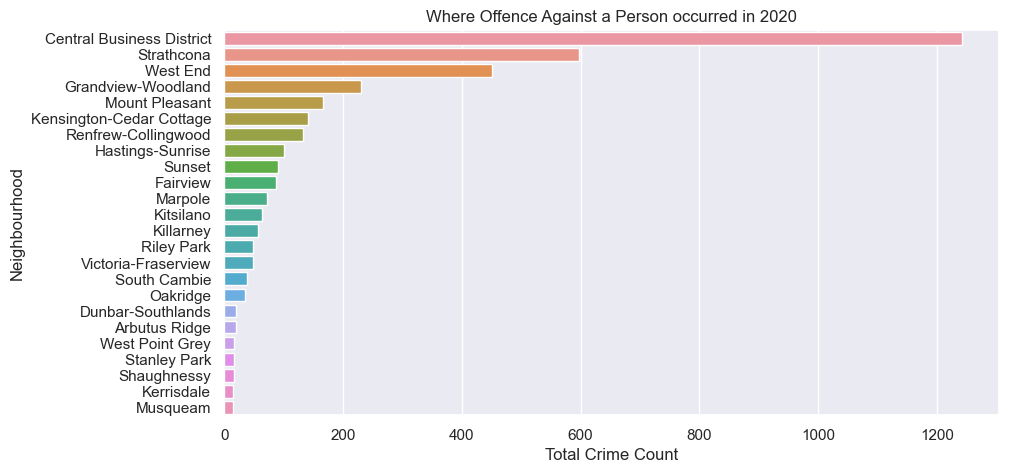

In [9]:
# plot 2 
where_crime_plot('Offence Against a Person')

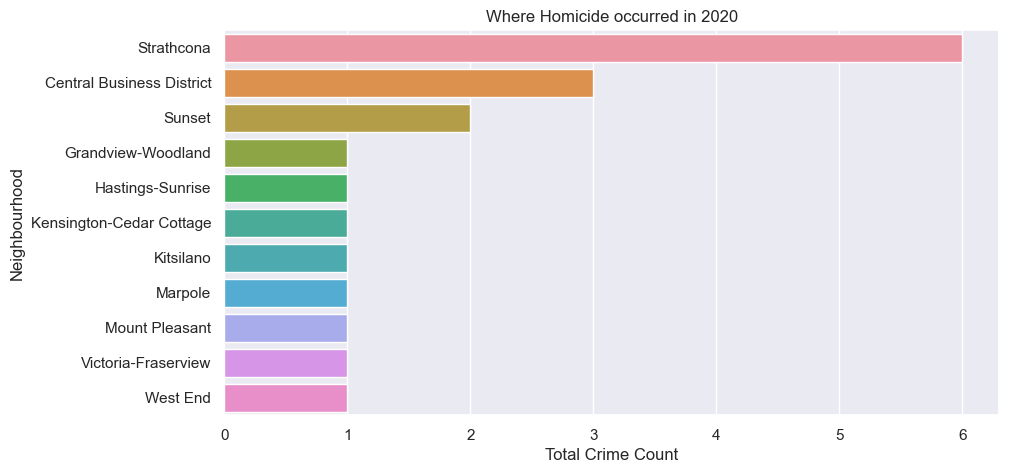

In [10]:
# plot 3
where_crime_plot('Homicide')

### Part 2: Creating an interactive heat map with Folium
Another tool to help visualize crime occurence in different neighbourhoods

#### Will now use the function to create several plots of personal interest.
I will also add an interactive component to the map by creating a dropdown menu for the user to select Neighbourhood of interest. Seeing the data for all neighbourhoods at once can be overwhelming, so this feature is here to make help break down the visualization experience.

In [11]:
import ipywidgets as widgets
from IPython.display import display

''' Will declare a function that takes crime type as the input parameter
    and returns a heat map with that crime occurrences labeled with 
    the month the crime took place in. 
    
    Will also add a dropdown selection widget to select a neighbourhood
    of intrest to display the heat map for.
    '''

def map_crime(crime):
    
    # create new df with filtered crime type
    crime_df = data2020[data2020['TYPE']==crime]
    
    # convert X,Y parameters to coordinates in degrees
    crime_df = utm_to_degrees(crime_df)
    
    # create a list of neighbourhoods for the drop down interactive filter
    neighbourhoods = ['All']+crime_df['NEIGHBOURHOOD'].unique().tolist()
    
    # create map widget for drop down menu
    dropdown = widgets.Dropdown(options=neighbourhoods, description='Select', disabled=False)
    
    def update_map(change):
        selection = dropdown.value
        
        if selection == 'All':
            df = crime_df.copy()
        else:
            df = crime_df[crime_df['NEIGHBOURHOOD']==selection]
        
        # convert X,Y parameters to coordinates in degrees
        df = utm_to_degrees(df)
        
        #create Vancouver map with Queen Elizabeth park as starting coordinates
        QEP_coordinates = [49.242222, -123.115]
        van_map = folium.Map(location=QEP_coordinates, zoom_start=10)

        #Add heat data to the map
        heat_data = [[row['lon'], row['lat']] for index, row in df.iterrows()]
        HeatMap(heat_data, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(van_map)

        occurrence = folium.map.FeatureGroup()

        # Create individuaal occurence objects on the map
        for lon, lat in zip(df.lon, df.lat):
            occurrence.add_child(
                folium.CircleMarker(
                    [lon,lat],
                    radius = 5,
                    color='gray',
                    fill = True,
                    fill_color = 'blue',
                    fill_opacity = 0.5   
                )
            )

        occurrence = MarkerCluster().add_to(van_map)

        # Label each occurrence on the map
        for lon, lat, label in zip(df.lon, df.lat, df.MONTH):
            folium.Marker(
                location = [lon,lat],
                icon = None,
                popup = 'Month: '+str(label)
                ).add_to(occurrence)

        van_map.add_child(occurrence)
        
        display(van_map)
        return
    
    dropdown.observe(update_map,'value')
    
    # Display the initial map
    #update_map(None)
    
    # Display the neighborhood dropdown
    display(dropdown)
    
    return 

''' This function will convert utm zone 10 coordinates to degrees,
    order for folium to create a heat map'''

def utm_to_degrees(df):
    utm_zone = pyproj.Proj(proj='utm', zone=10, ellps='WGS84')

    lat, lon = utm_zone(df['X'].values, df['Y'].values, inverse=True)

    df['lon'] = lon
    df['lat'] = lat

    return df

### To illustrate the feature I will display the following maps
1) Residential break and enter in Marpole
2) Bike theft in Kitsilano
3) Vehicle theft in West End

In [12]:
map_crime('Break and Enter Residential/Other')


Dropdown(description='Select', options=('All', 'West End', 'Central Business District', 'Grandview-Woodland', …

In [13]:
map_crime('Theft of Bicycle')

Dropdown(description='Select', options=('All', 'West End', 'Central Business District', 'Grandview-Woodland', …

In [14]:
map_crime('Theft from Vehicle')

Dropdown(description='Select', options=('All', 'Central Business District', 'West End', 'West Point Grey', 'Re…

Similarly the map can be used to analyze crime trends in other years as well.
